# Causal Machine Learning for Treatment Effect Estimation

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

#from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans

from sklearn.preprocessing import Normalizer

# get standard models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

from sources.doubly_robust import doubly_robust
from sources.models.TARNet import TARnetICFR
from significance import *

import pickle
import torch
import torch.nn as nn
import torch.optim as optim

from auxiliary import data_processing, doubly_robust, visualise, visualise_ites, impute_missing_values_knn, run_model, undersample, full_contra_indications_tracker, value_based_contra_indications_tracker, period_decomposition, multicol
from icodes import encoding

# from datetime import timedelta
import warnings 
warnings.filterwarnings('ignore')

## 1. Introduction

The purpose of this notebook is to provide and end-to-end description of the treatment effect estimation process. This notebook consists of three parts:

1. **Data processing**: The first part is the data processing part. Here we basically prepare the data for the ML models.
2. **Causal ML Models**: The second part of the notebook consists of a series of causal ML learning models. In particular, we use the causal meta-learning framework. 
3. **Adadptive Model**: The third part of the notebook is also a machine learning model. However, contrary to the models before, this one was developed by the VU team and allows for more control over the estimation proces. 

Please find below an overview of the steps we will go through. Note that the boxes do not correspond one-to-one to sections in the notebook, but the general flow is the same. 

![alt text](images\ModellingOverview.jpg)

## 1.a. Preliminaries \& Design Choices

We first want to get some preliminaries out of the way. In particular, we would like to make some specific **design choices** explicit. Below, we can set the following parameters, thereby modifying specific choices:

- ``EXPOSURE_THRESHOLD``: The treatment is binary. However, how much treatment is provided can be changed with this variable. In essence, it determines the cut-off value. For instance, we can set it to 60 minutes in the case of physical therapy (in mins.). Then, patients with more then 60 minutes of PT will be assigned T=1, those below will be T=0.
- ``PERIOD_MIN``: Minimal time period between baseline measurement and followup measurement. N.B. If this is set too low, the effect may not yet register. Too high and the effect may have faded out. 
- ``PERIOD_MAX``: Maximal time period between baseline measurement and followup measurement. N.B. If this is set too low, effect may not yet register. Too high and the effect may have faded out.  
- ``REMOVE_MULTI_COL``: Whether or not to remove multicollinear columns. 
- ``CORRELATION_THRESHOLD``: Threshold for removing collinear columns. 
- ``UNDERSAMPLE``: Some models perform better when undersampling the minority class. For instance, if there are 1000 cases of patients with PT (T=0) and only 150 with PT (T=1), setting this to ``True`` ensures that 150 patients are sampled from PT (T=0), resulting in 300 observations in total.
- ``IMPUTE``: Whether or not to impute missing *covariate* values.
- ``PROPENSITY``: Whether or not to add a propensity score to the model.
- ``CLEAN_COMPARE``: By default (when this is set to ``False``), the data processing script assigns any observations below ``EXPOSURE_THRESHOLD`` to the control group and  any observation above ``EXPOSURE_THRESHOLD`` to treated. Setting this parameter to ``True`` creates a scenario where *only* observation that did not get any treatment are assigned to the control group. For instance, in the case of PT, we would have a control group of patients getting only 0 mins. of PT and a treated group of patients with, say, more than 60 mins. of PT.
- ``TREATMENT``: Name of the treatment variable.
- ``TARGET``: Name of the target variable.

In [71]:
# set seed
np.random.seed(42)

# set the exposure threshold for binary dichtomization. In the case of PT, 60 minutes of PT at least. 
EXPOSURE_THRESHOLD = 45#30 # SET TO 30

# set the period between observations. We only consider the effects between 120 and 240 days after exposure. 
PERIOD_MIN = 20 # /MAYBE CHECK WITH 60? 
PERIOD_MAX = 190 # CHECK WITH 120 DAYS 

# if we want to move multicollinear columns, set to True
REMOVE_MULTI_COL = True

# set the threshold for multicollinearity drops 
CORRELATION_THRESHOLD = 0.6

# set to True if we want to undersample
UNDERSAMPLE = True #False #True

# set to True if we want to impute missing values
IMPUTE = True

PROPENSITY = True

# clean compare (to be used if only > threshold AND treatment = 0)
CLEAN_COMPARE = True

TREATMENT = 'in3eb' # (minutes or days of physical therapy)
OUTCOME = 'sADLSF' 

Having set the desired parameters, we will now read in the data.

In [72]:
file = "data/dutch_LTCF_all.csv"

# read data
df = pd.read_csv(file)
print(f"Treatment before processing {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

Treatment before processing 3462


In [73]:
# code for date

## Part 2. Data Processing

In this first part, we will carry out the data processsing. In particular, we would like to select the relevant covariates, make a pre-selection based on patient characteristics (e.g. whether or not contra-indications are present), select the relevant period of observation, impute missing *coviariate* values and, lastly, handle any multi-collinearity. 

Next, we define the lists of covariates, clinical indications and contra-indications

In [74]:
#contra_indications = ['ij2e', 'ij2l', 'ij2n', 'ij2t', 'ij2q', 'ij2r', 'ij6b', 'ij6c',  'in6b', 'in6c'] 

#BIGGER THAN
contra_indications = {'sCPS': [4, 5], 'in2a': [2,3],
                                 'in2c': [2,3], 'in2e': [2,3], 'in2f': [2,3],
                                 'in2g': [2,3], 'in2h':[2,3], 'in2i':[2,3],
                                 'in2j':[2,3], 
                                  'ij2e': [1,2,3,4,5,6,7,8], 'ij2l': [1,2,3,4,5,6,7,8]
                                 , 'ij2n': [1,2,3,4,5,6,7,8], 'ij2t': [1,2,3,4,5,6,7,8]
                                 , 'ij2q': [1,2,3,4,5,6,7,8], 'ij2r': [1,2,3,4,5,6,7,8]
                                 , 'ij6b': [1,2,3,4,5,6,7,8], 'ij6c': [1,2,3,4,5,6,7,8]
                                 , 'in6b': [1,2,3,4,5,6,7,8,9], 'in6c': [1,2,3,4,5,6,7,8,9]}

# also convert values to list for ease of processing later on
#listed_val_based_ind = [key for key, value in value_based_contra_indications.items()]

#contra_indications = contra_indications #+ listed_val_based_ind

# list relevant confounders
confounders = ['ik3',  'id4a', 'ie3e', 'ih1', 
                        'ih3', 'ih5', 'ij6a',  
                        'il7', 'il1',  'sCPS', 'iA2', 'sAGE_cat']

# list clinical indications
clinical_indications = {'sDRS': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], 'ij1': [1,2,3,4,5,6,7,8], 'ij12': [1,2,3,4,5,6,7,8], 
                      'ij2a': [1,2,3,4,5,6,7,8], 'ij2b': [1,2,3,4,5,6,7,8], 'ij2c': [1,2,3,4,5,6,7,8], 
                      'ij2d': [1,2,3,4,5,6,7,8]}
   
            
# ADD VALUE BASED CLINICAL INDICATIONS, E.G. {'sDRS' : [3,4]}

# list of other relevant variables
relevant_vars = ['iA9', 'Clientid', TREATMENT, OUTCOME]

print(len(contra_indications))

19


Please note that you can get the meaning of the icodes by running the ``encoding``-function below. You only need to change the name of the ``code`` variable.

In [75]:
code = 'ih3'
print(encoding[(code).lower()])

Bowel continence


### 2.a. Indications

In [76]:
mask = pd.Series(False, index = df.index)

for column, good_values in clinical_indications.items():
    mask |= df[column].isin(good_values)
    
df_included = df[mask]
df = df_included

In [77]:
#df_included

### 2a. Contra-indications

Next, the first thing we want to do is to drop patients that have a contra-indication for the treatment in questions. In the code below, we specify the contra-indications. 

Finally, for some contra-indications we want to exclude based on particular values only. We can do this by running the script below. 

In [78]:
for column, bad_values in contra_indications.items():
    df = df[~df[column].isin(bad_values)]

Having processed the contra-indications, we can now select the necessary columns in the data.

In [79]:
df = df[list(clinical_indications.keys())+confounders + relevant_vars + list(contra_indications.keys())]
print(f"Treatment after selecting covariates {len(df[df[TREATMENT]>=EXPOSURE_THRESHOLD])}")

Treatment after selecting covariates 1770


In [80]:
df#[df['sDRS']!=0]

,sDRS,ij1,ij12,ij2a,ij2b,ij2c,ij2d,ik3,id4a,ie3e,...,ij2e,ij2l,ij2n,ij2t,ij2q,ij2r,ij6b,ij6c,in6b,in6c
0,0.0,0.0,NaN,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,0.0,0.0,4.0,0.0,4.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,1.0,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,7.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,2.0,2.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48130,3.0,3.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48132,8.0,3.0,0.0,4.0,4.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48133,8.0,3.0,0.0,4.0,4.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48134,12.0,2.0,1.0,2.0,2.0,3.0,4.0,NaN,NaN,3.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.b. Baseline-Followup Selection

Important to note here is that in this particular setup, our goal is to **estimate the outcome value at follow up from the covariates *and* outcome variable at baseline**. 

Below you find a schematic depiction of how we want to process the data. As you can see, there are two timelines:

1. **Timeline 1**: Naturally processes from baseline to follow up over time, without any intervention in the meantme.
2. **Timeline 2**: Same as before, but with the difference that not an intervention has take place at some point in time between baseline and follow up. 

![alt text](TimelineModels.jpg)

Our goal is therefore to, *for each observation*, take the values (**pre-treatment** covariates, outcome on baseline $y_{t}$) of baseline, and the  values at follow up (outcome on follow up $y_{t+1}$) and store it in a convenient manner. Important to note is that as patient may have *several* of these baseline-followup recors where sometimes an intervention may have occured and sometimes not. We decided to do this to, again, safe as much data as possible. 

Let us begin by first counting the number of assesments. We do this, because it is not possible to include patients without followup. 

In [81]:
# get number of assesments
counter = lambda x: len(df[df['Clientid']==x])

# count number of items
df['num_assesments'] = df['Clientid'].apply(counter)

Let us select only observations with more than 2 assesments. 

In [82]:
# get number of assesments higher than 1
df = df[df['num_assesments']>=2]

print(f'{len(df)} observations remaining.')
print(f"Treatment after selecting on number of assesments {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

16368 observations remaining.
Treatment after selecting on number of assesments 1346


In the code below, we want to process the data a bit further. First, we want to make sure that the date columns (``iA9``) is in the correct format. Then we want to order based on ID and date. Also, we want to drop missing dates (if there are any) and drop any duplicated observations. Lastly, we want to make sure that the outcome is in the right format (i.e. a ``float``).

In [83]:
# convert column to datetime 
df['iA9'] = pd.to_datetime(df['iA9']) 
# sort values by ID and date
df = df.sort_values(by = ['Clientid', 'iA9'])
# drop nans on dates of assesment
df = df[df['iA9'].isna()==False]
# drop duplicated values
df = df.drop_duplicates()
df[OUTCOME] = df[OUTCOME].astype(float)

### 2.c Drop Duplicated Values

Next, because there may be two assesments on the same date, we also want to drop those (regardless of the reason as inspecting that is beyond the scope of this project notebook). 

In [84]:
# Group by 'Clientid' and then apply the duplicate check on 'iA9' within each group
duplicated_indices = df.groupby('Clientid').apply(
    lambda x: x[x['iA9'].duplicated()].index).explode()

# Drop NaN values from the index list if they exist
duplicated_indices = duplicated_indices.dropna()

# Convert the result into a list if it's not empty
if not duplicated_indices.empty:
    duplicated_indices = duplicated_indices.tolist()

    # Drop the duplicates using the list of indices
    df = df.drop(index=duplicated_indices)

### 2.d. Clean Compare
If we want to only compare between those patients that receive either 0 treatment or a treatment above the threshold value, we run this code.

In [85]:
if CLEAN_COMPARE:
    df = df[(df[TREATMENT] <= 0) | (df[TREATMENT] >= EXPOSURE_THRESHOLD)]

### 2.e Period Decomposition

The piece of code (i.e. the function ``period_decomposition``) below is a loop that basically does the following:

1. Create a temporary dataframe ``temp_df``. We do this to make sure that there is an empty entity (i.e. data storage) to which we can append new, cleaned and processed observations.
2. Then, for each patient we do the following:
3. Look at all the observation dates.
4. Select the target outcome at follow up and at baseline.
5. Append each period to the ``temp_df`` *until running out of dates*. 
6. Move to the next patient. 

In [86]:
def period_decomposition(df, target):
    # List to store the rows of the new DataFrame
    rows = []

    # Unique client IDs
    client_ids = df['Clientid'].unique()
    total = len(client_ids)

    for count, client_id in enumerate(client_ids, start=1):
        # Inform the user about the progress
        if count % 1000 == 0 or count == total:
            print(f'{count} of {total} items completed...')

        # Extract rows for the current client
        client_rows = df[df['Clientid'] == client_id].sort_values('iA9')
        client_dates = client_rows['iA9'].tolist()

        for i in range(len(client_dates) - 1):
            baseline_date = client_dates[i]
            followup_date = client_dates[i + 1]

            # Extract the rows for baseline and follow-up
            baseline_row = client_rows[client_rows['iA9'] == baseline_date]
            followup_row = client_rows[client_rows['iA9'] == followup_date]

            # Calculate the outcomes
            outcome_t0 = float(baseline_row[target])
            outcome_t1 = float(followup_row[target])

            # Prepare a new row with all necessary information
            new_row = baseline_row.iloc[0].to_dict()
            new_row['OutcomeT0'] = outcome_t0
            new_row['OutcomeT1'] = outcome_t1
            new_row['OutcomeT0Date'] = baseline_date
            new_row['OutcomeT1Date'] = followup_date
            rows.append(new_row)

    # Create a new DataFrame from the list of new rows
    temp_df = pd.DataFrame(rows)
    print("Completed.")
    return temp_df


In [87]:
df = period_decomposition(df, target = OUTCOME)
print(f"Treatment after processing {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

1000 of 3314 items completed...
2000 of 3314 items completed...
3000 of 3314 items completed...
3314 of 3314 items completed...
Completed.
Treatment after processing 927


### 2.f Dichotomize Treatment Variable

Because our model can only deal with binary treatments, we need to convert the continuous treatments into binary ones. We will do that using a simple fuctions. Recall that the threshold has been set using the ``EXPOSURE_THRESHOLD`` variable above.

In [88]:
binary = lambda x: 1 if x >= EXPOSURE_THRESHOLD else 0
# convert treatment to binary
df['treatment'] = df[TREATMENT].apply(binary)  
df = df.drop(columns = [TREATMENT])

In [89]:
# drop rows with missing outcome or treatment 
df = df.dropna(subset = ['OutcomeT0', 'OutcomeT1', 'treatment'])
df.head(3)

,sDRS,ij1,ij12,ij2a,ij2b,ij2c,ij2d,ik3,id4a,ie3e,...,ij6b,ij6c,in6b,in6c,num_assesments,OutcomeT0,OutcomeT1,OutcomeT0Date,OutcomeT1Date,treatment
4,5.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3,2.0,2.0,2006-08-01,2006-08-13,0
5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2,7.0,7.0,2006-05-30,2006-08-15,0
11,1.0,0.0,0.0,2.0,2.0,0.0,4.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,4,0.0,0.0,2006-07-14,2006-07-28,0


In [90]:
df

,sDRS,ij1,ij12,ij2a,ij2b,ij2c,ij2d,ik3,id4a,ie3e,...,ij6b,ij6c,in6b,in6c,num_assesments,OutcomeT0,OutcomeT1,OutcomeT0Date,OutcomeT1Date,treatment
4,5.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3,2.0,2.0,2006-08-01,2006-08-13,0
5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2,7.0,7.0,2006-05-30,2006-08-15,0
11,1.0,0.0,0.0,2.0,2.0,0.0,4.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,4,0.0,0.0,2006-07-14,2006-07-28,0
12,1.0,0.0,0.0,2.0,2.0,0.0,4.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,4,0.0,2.0,2006-07-28,2006-08-25,0
17,0.0,0.0,0.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12,5.0,5.0,2006-05-29,2006-08-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8939,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2,0.0,0.0,2022-07-05,2022-10-10,0
8940,1.0,3.0,1.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2,3.0,6.0,2019-07-08,2020-10-07,0
8941,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2,0.0,0.0,2018-10-16,2019-04-09,1
8942,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3,3.0,2.0,2020-10-21,2021-04-13,0


### 2.g Select Relevant Period

Because the base data is too crude (the time periods between follow-up and baseline may be too far apart), we want to select a suitable period between observations. In essence, we aim to select a time window which is, on the one hand, determined by the minimum time (``PERIOD_MIN``) between baseline measurement and follow-up measurement and the maximum of that time window (``PERIOD_MAX``).

In [91]:
# get difference between dates
df['date_diff'] = df['OutcomeT1Date'] - df['OutcomeT0Date'] 
df['date_diff'] = df['date_diff'].dt.days 

# select relevant period
df = df[df['date_diff'] <= PERIOD_MAX]
df = df[df['date_diff'] >= PERIOD_MIN]

df = df.drop(columns = ['OutcomeT1Date', 'OutcomeT0Date', 'date_diff', 'iA9', OUTCOME, 'Clientid'])
# examine how many treatment observations are left
len(df[df['treatment']==1])

497

### 2.h Impute Missing Values

In this part, we impute missing values. We use a standard KNN-imputer. If desired, it is possible to change the number of neighbours. Keep in mind that we can set this to ``False`` if we do not want to run it,

In [92]:
#imputing = IMPUTE
if IMPUTE:
    df = impute_missing_values_knn(df, n_neighbors=5)
else:
    df = df.dropna()
    print(len(df[df['treatment']==1]))

### 2.i Handle Multicollinearity

Here we will handle multi-collinear columns. Keep in mind that we can set this to ``False`` if we do not want to run it,

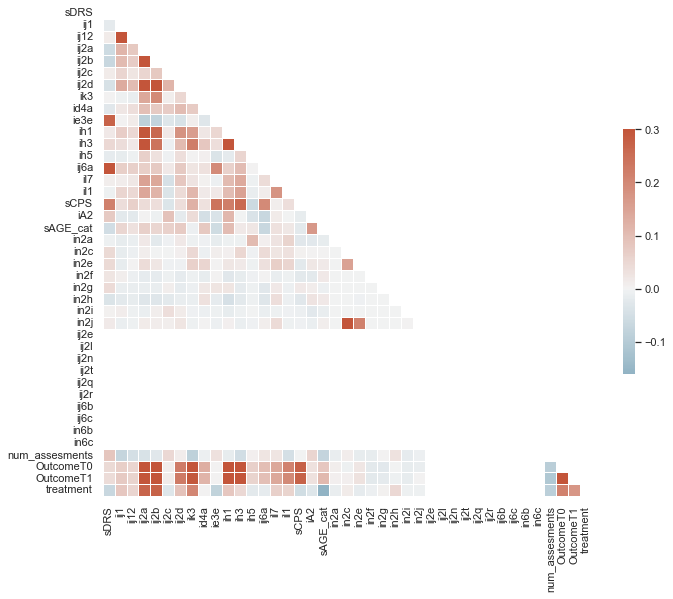

In [93]:
if REMOVE_MULTI_COL:
    df = multicol(df, CORRELATION_THRESHOLD)

### 2.j Handle Empty Columns

In the process, it may be that we end up with columns that contain only $0$ values. We want to drop these columns, as they are not informative.

In [94]:
# drop num_assesment column, not relevant anymore
df = df.drop(columns = ['num_assesments'])
# get a list of coviariate columns
X = df.drop(columns = ['OutcomeT1', 'OutcomeT0', 'treatment']).columns

# drop columns that only have 0 values
for col in X:
    if len(df[df[col]==0]) == len(df):
        print(f"{col} - {encoding[col.lower()]} dropped." )
        df = df.drop(columns = [col])

ij2e - Chest pain dropped.
ij2l - Diarrhea dropped.
ij2n - Vomiting dropped.
ij2t - Aspiration dropped.
ij2q - Fever Aspiration dropped.
ij2r - GI or GU bleeding dropped.
ij6b - Experiencing an acute episode, or a flare-up of a recurrent or chronic problem dropped.
ij6c - End-stage disease, 6 or fewer months to live dropped.
in6b - Unkown dropped.
in6c - Unkown dropped.


### 2.k Store CSV

In the last part of this notebook, we will store that data.

In [95]:
X = df.drop(columns = ['OutcomeT1', 'OutcomeT0', 'treatment']).columns

In [96]:
# treatment = TREATMENT#'in3eb' # (minutes or days of physical therapy)
# target = #'sADLSF' 

#df = df.drop(columns = 'num_assesments')
df.to_csv(f"data/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv", index = False)

In [97]:
# ADD SKIP FOR TREATMENT AND OUTCOME T1
covars = [str(i) for i in df.columns]
covar_names = []

#print(encoding[(code).lower()])

for covar in covars:
    if (covar != 'treatment') and (covar != 'OutcomeT1'):

        try:
            covar_names.append(encoding[(covar).lower()])
        except:
            covar_names.append(covar)
            
            

In [98]:
# ADD SKIP FOR TREATMENT AND OUTCOME T1
covars = [str(i) for i in df.columns]
covar_names = []

#print(encoding[(code).lower()])

for covar in covars:
    if (covar != 'treatment') and (covar != 'OutcomeT1'):

        try:
            covar_names.append(covar)
        except:
            covar_names.append(covar)

In [99]:
covar_names

['sDRS',
 'ij12',
 'ij2b',
 'ij2c',
 'ij2d',
 'ik3',
 'id4a',
 'ie3e',
 'ih1',
 'ih3',
 'ih5',
 'ij6a',
 'il7',
 'il1',
 'sCPS',
 'iA2',
 'sAGE_cat',
 'in2a',
 'in2c',
 'in2e',
 'in2f',
 'in2g',
 'in2h',
 'in2i',
 'in2j',
 'OutcomeT0']

### Note to Teams: Please Start Here

**MAKE SURE THAT THE DATA IS IN THE EXACT FORMAT AS BELOW.**

Checklist:

1. The covariates must come first.
2. Then, there must be the outcome at baseline called ``OutcomeT0``.
3. There must be an outcome at followup called ``OutcomeT1``.
4. You may have a propensity score columns (``ps``), but this is not required. Same for clusters.
5. There must be a treatment column *at the end* called ``treatment``. 

Good luck!

## Part 3. Machine Learning

Having processed the data, we can now move on the the machine learning (ML) part. Recall that we model using the meta-learning paradigm. Below is a schematic depiction of the process.

![alt text](images\ModelGoal.jpg)

As can be seen, for a given patient, we can - *after training* - provide the details of that patient. These details are the outcome at baseline (``OutcomeT0``), the covariates and whether or not we include treatment. This allows us to compute the **individual treatment effect** (ITE), the predicted effect unter treatment minus the predicted effect under control.

However, before we are able to estimate the ITE for a patient, we need to train the model. In meta-learning we always train two models. The first model is trained on the control group and the second model is trained on the treated group. Let us now first state what the ``outcome`` and ``intervention`` variables are.  

![alt text](images\GeneralPlotTrajectoryInterpretation.jpg)

Next, we want to select the models. Here we will use ``RandomForestRegressor()``.

In [100]:
model0 = RandomForestRegressor()
model1 = RandomForestRegressor()

In [101]:
model = model0

In [102]:
# File path for the Excel file
excel_file = f'data/hyperparameters/model_hyperparameters_RandomForest.xlsx'

# Create a Pandas Excel writer using XlsxWriter as the engine
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Get hyperparameters
    hyperparameters = model.get_params()

    # Convert to DataFrame
    df = pd.DataFrame([hyperparameters])

    # Write each model's hyperparameters to a different sheet
    df.to_excel(writer, sheet_name="RandomForest")

print("Hyperparameters of models have been saved to 'model_hyperparameters.xlsx'.")

Hyperparameters of models have been saved to 'model_hyperparameters.xlsx'.


Then, we want to retrieve the data. We can use the data from above, but here we will read the file. 

In [103]:
# call your data file here
FILE = f"data/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv"

Afterwards, we can run the model. The only thing to do is to run the ``run_model``-function below. 

In [104]:
machine = "RandomForest"

metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train, X_test_t, X_test_c = run_model(n_bootstraps = 1, file = FILE, model0 = model0, model1 = model1, undersampled = UNDERSAMPLE, include_propensity = PROPENSITY, intervention = TREATMENT, outcome = OUTCOME, machine = "RandomForest", num_iter = 1)

DF lenght after undersampling: 994
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
ATE: -0.10, 95% CI: [nan, nan]


We can first compute the confidence interval.

In [105]:
confidence_interval(data=ites_test)

(-0.4258997555125603, -0.07511524448743953)


In [106]:
significance(data=ites_test)

T-statistic: -2.8164864096475397
P-value: 0.005344216974260254
Result is statistically significant


In [38]:
# sample_mean = np.mean(ites_test)
# stdev = np.std(ites_test, ddof=1)
# n = len(ites_test)
# degfree = n-1
# confidence = 0.95
# t_score = stats.t.ppf((1+confidence)/2,degfree)
# margin_of_error = t_score * (stdev / np.sqrt(n))

# conf_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)
# print(conf_interval)

In [39]:
# pop_mean = 0
# t_statistic, p_value = stats.ttest_1samp(ites_test, pop_mean)
# alpha = 0.05

# print(f"T-statistic: {t_statistic}")
# print(f"P-value: {p_value}")

# if p_value < alpha:
#     print("Result is statistically significant")
    
# else:
#     print("Result is not significant")

We can now examine the performance of the model by calling ``metrics``.

In [40]:
metrics

,RandomForest
MAE_C,0.712426
MAE_T,1.324483
MSE_C,1.258423
MSE_T,5.013997
R2_C,0.928778
R2_T,0.701826


We can also visualise the model's *factual* predicted performance by calling the ``visualise`` function.

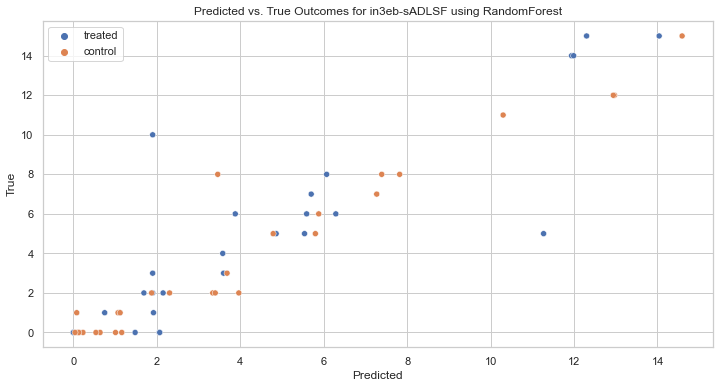

In [41]:
machine = "RandomForest"
visualise(predictions_t, predictions_c, y_test_t, y_test_c, machine=machine, target=OUTCOME, intervention=TREATMENT)

Also, if we want to visualize the ITES, we can run the following function (``visualise_ites``):

ATE -1.0504248768472906


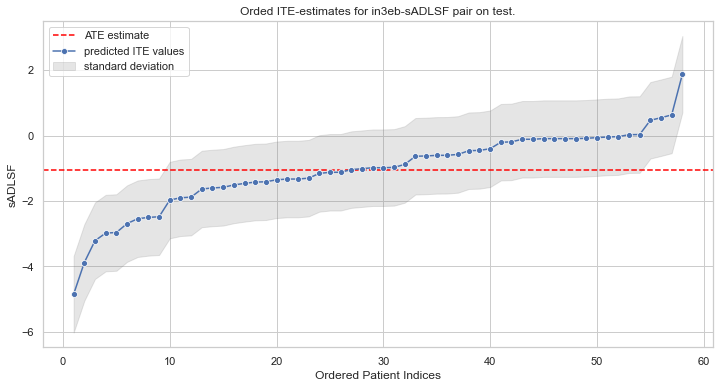

In [42]:
visualise_ites(ites_test, machine = machine, intervention = TREATMENT, target = OUTCOME)

ATE -0.8614439655172415


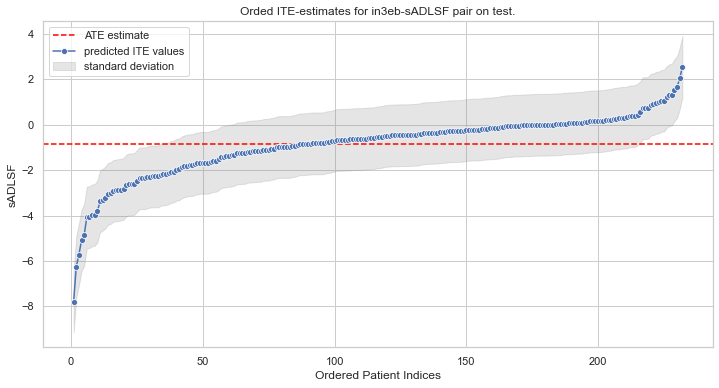

In [43]:
visualise_ites(ites_train, machine = machine, intervention = TREATMENT, target = OUTCOME)

### 3.b Run More Models

These models can be run also. Feel free to remove some of the models, but please run at least:

- ``RandomForestRegressor()``
- ``GradientBoostingRegressor()``
- ``LinearRegression()``

RandomForestRegressor()
DF lenght after undersampling: 290
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
ATE: 0.23, 95% CI: [nan, nan]
ATE 0.07416666666666669


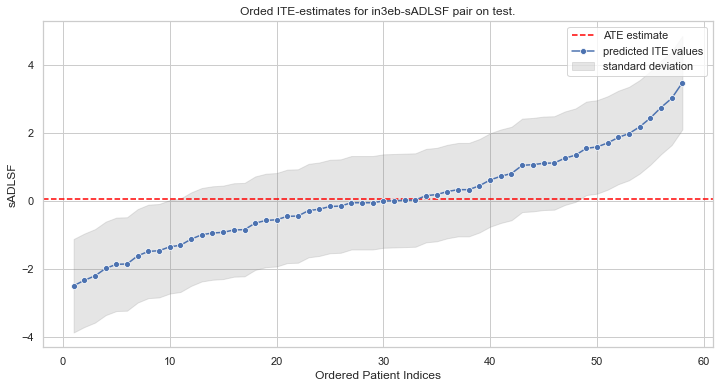

(-0.29022140010415554, 0.43855473343748885)
T-statistic: 0.4075769809236286
P-value: 0.6851110389495481
Result is not significant
       RandomForestRegressor()
MAE_C                 1.022414
MAE_T                 1.429799
MSE_C                 2.264079
MSE_T                 3.235147
R2_C                  0.822018
R2_T                  0.767500
MLPRegressor()
DF lenght after undersampling: 290
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
ATE: -0.29, 95% CI: [nan, nan]
ATE -0.2875334714585401


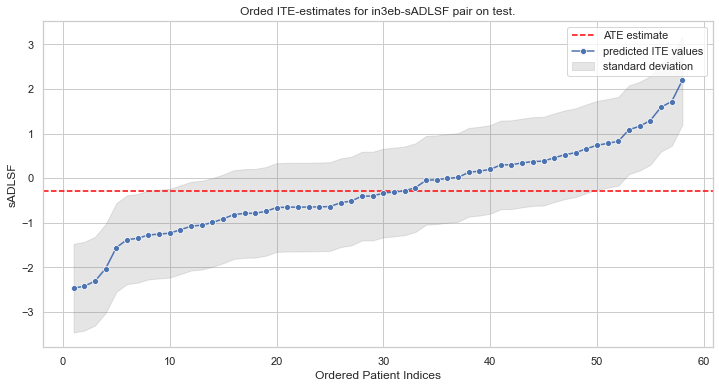

(-0.5512001259213632, -0.02386681699571691)
T-statistic: -2.183726439747573
P-value: 0.033112914867829565
Result is statistically significant
       MLPRegressor()
MAE_C        0.549943
MAE_T        1.145385
MSE_C        0.831170
MSE_T        2.432643
R2_C         0.905218
R2_T         0.846533
GradientBoostingRegressor()
DF lenght after undersampling: 290
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
ATE: -0.58, 95% CI: [nan, nan]
ATE -0.5533917705830551


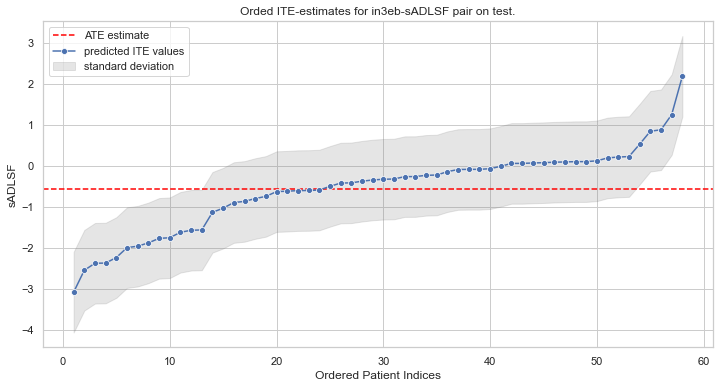

(-0.814618776907509, -0.2921647642586013)
T-statistic: -4.242087833705376
P-value: 8.224864586552383e-05
Result is statistically significant
       GradientBoostingRegressor()
MAE_C                     0.696897
MAE_T                     1.649838
MSE_C                     1.550948
MSE_T                     5.626487
R2_C                      0.907795
R2_T                      0.576597
DecisionTreeRegressor()
DF lenght after undersampling: 290
{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
ATE: -0.36, 95% CI: [nan, nan]
ATE -0.28448275862068967


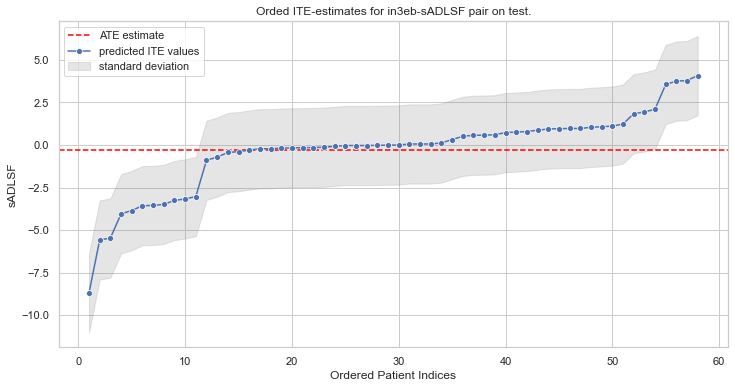

(-0.9019459997411898, 0.3329804824998104)
T-statistic: -0.9225924064989687
P-value: 0.36010853242223184
Result is not significant
       DecisionTreeRegressor()
MAE_C                 0.947931
MAE_T                 1.724138
MSE_C                 4.392624
MSE_T                 5.724138
R2_C                  0.686404
R2_T                  0.724820
LinearRegression()
DF lenght after undersampling: 290
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
ATE: 0.07, 95% CI: [nan, nan]
ATE -0.13301037662595552


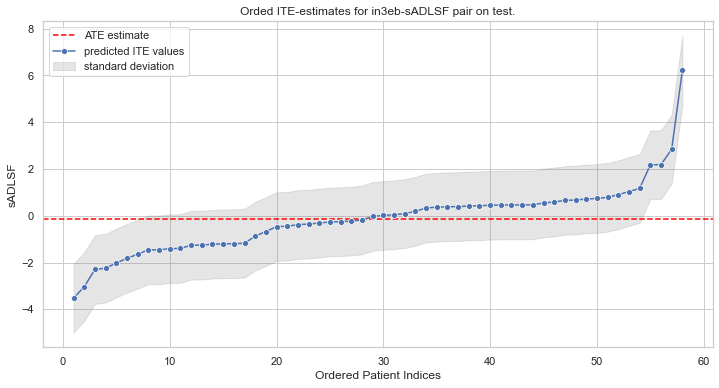

(-0.5223111557825251, 0.25629040253061386)
T-statistic: -0.6841719796537792
P-value: 0.4966388923726798
Result is not significant
       LinearRegression()
MAE_C            0.944828
MAE_T            1.869750
MSE_C            2.081062
MSE_T            7.931051
R2_C             0.789378
R2_T             0.276547
Ridge()
DF lenght after undersampling: 290
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
ATE: -0.18, 95% CI: [nan, nan]
ATE -0.12942130307131905


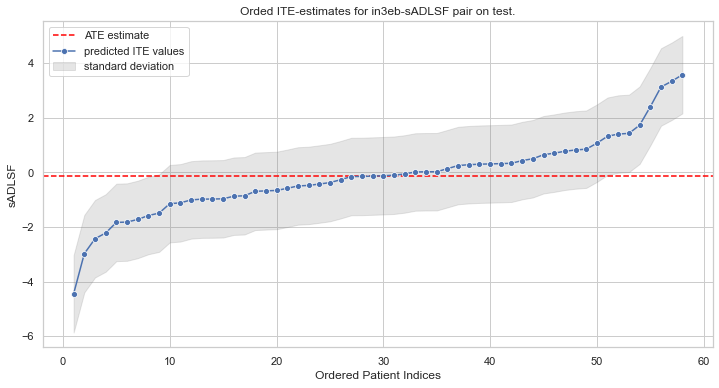

(-0.5059614717051797, 0.24711886556254153)
T-statistic: -0.6882710279676298
P-value: 0.49407383481470546
Result is not significant
        Ridge()
MAE_C  1.266552
MAE_T  1.170688
MSE_C  3.478369
MSE_T  2.511139
R2_C   0.745332
R2_T   0.879653
Lasso()
DF lenght after undersampling: 290
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
ATE: -0.52, 95% CI: [nan, nan]
ATE -0.32658091911582465


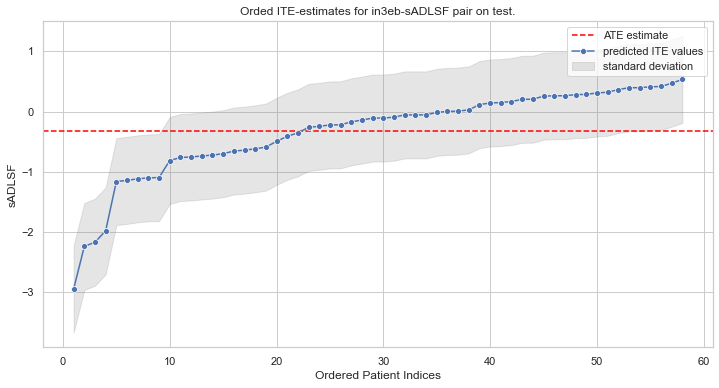

(-0.5181550929327364, -0.13500674529891288)
T-statistic: -3.4136491196050285
P-value: 0.0011862628474311684
Result is statistically significant
        Lasso()
MAE_C  0.452069
MAE_T  0.896568
MSE_C  0.570174
MSE_T  1.668115
R2_C   0.938844
R2_T   0.854737
AdaBoostRegressor()
DF lenght after undersampling: 290
{'base_estimator': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50, 'random_state': None}
ATE: -0.05, 95% CI: [nan, nan]
ATE -0.2508023033997457


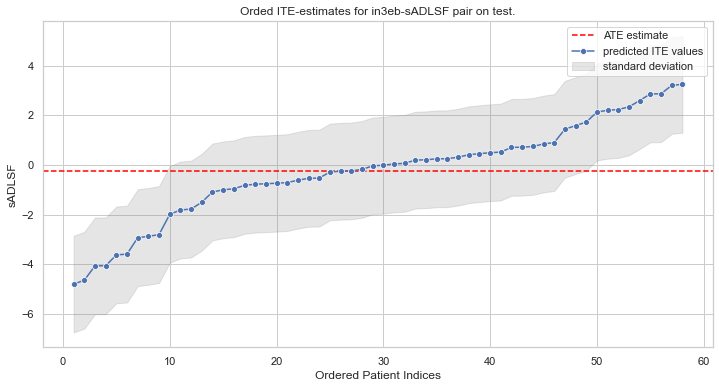

(-0.7678731388550636, 0.2662685320555723)
T-statistic: -0.9712846188980601
P-value: 0.33551030820686134
Result is not significant
       AdaBoostRegressor()
MAE_C             1.534138
MAE_T             1.396056
MSE_C             9.379507
MSE_T             3.856922
R2_C             -0.064467
R2_T              0.756413
ExtraTreesRegressor()
DF lenght after undersampling: 290
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
ATE: -0.37, 95% CI: [nan, nan]
ATE -0.8189655172413793


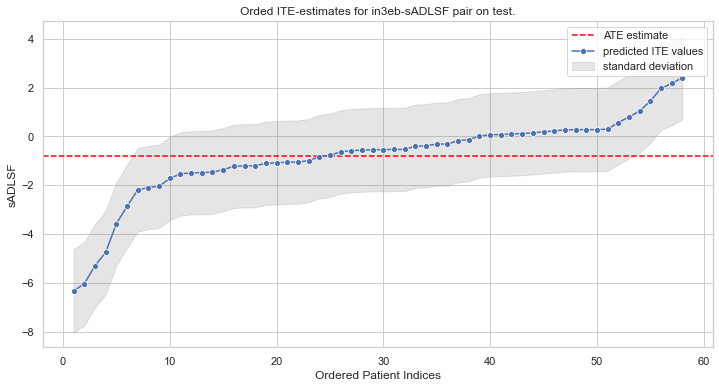

(-1.2716187585485397, -0.366312275934219)
T-statistic: -3.6229723107203964
P-value: 0.0006211896530449108
Result is statistically significant
       ExtraTreesRegressor()
MAE_C               1.116897
MAE_T               1.065517
MSE_C               4.533734
MSE_T               3.187952
R2_C                0.640324
R2_T                0.829644
BaggingRegressor()
DF lenght after undersampling: 290
{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
ATE: -0.11, 95% CI: [nan, nan]
ATE -0.192816091954023


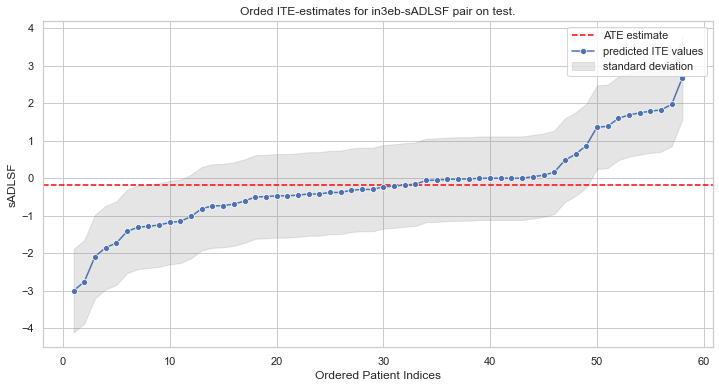

(-0.488198704186097, 0.10256652027805102)
T-statistic: -1.3071438463400686
P-value: 0.19641253414359933
Result is not significant
       BaggingRegressor()
MAE_C            0.657241
MAE_T            1.687931
MSE_C            1.469297
MSE_T            6.634914
R2_C             0.900171
R2_T             0.523864


In [70]:
model_lst = [(RandomForestRegressor(),RandomForestRegressor()), (MLPRegressor(), MLPRegressor()), 
            (GradientBoostingRegressor(), GradientBoostingRegressor()), (DecisionTreeRegressor(), DecisionTreeRegressor()),
            (LinearRegression(), LinearRegression()), (Ridge(), Ridge()), (Lasso(), Lasso()),
            (AdaBoostRegressor(), AdaBoostRegressor()), (ExtraTreesRegressor(), ExtraTreesRegressor()), 
             (BaggingRegressor(), BaggingRegressor())]

for model1, model2 in model_lst:
    print(str(model1))
    metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train, X_test_t, X_test_c = run_model(n_bootstraps = 1, file = FILE, include_propensity = PROPENSITY, outcome=OUTCOME, intervention=TREATMENT, undersampled = UNDERSAMPLE, model0 = model0, model1 = model1, machine = str(model1), num_iter = 1)
    #visualise(predictions_t, predictions_c, y_test_t, y_test_c, machine=machine, target=target, intervention=intervention)
    visualise_ites(ites_test, machine = str(model1), intervention = TREATMENT, target = OUTCOME)
    confidence_interval(data=ites_test)
    significance(data=ites_test)
    print(metrics)

## Part 4. Adaptive Model

In this last part, we will predict the treatment effect using an adaptive model. This model was developed by us. As can be seen, there is a bit more coding involved, but the benefit is that it is easier to adapt this model to our preferences. 

The first step is to make sure that our model runs on the proper device. 

In [45]:
device = torch.device("cpu")

It is useful to have a small function that easily converts arrays to the correct ``torch``-objects: tensors.

In [46]:
to_tensor = lambda x: torch.tensor(np.array(x), dtype = torch.float32).to(device)

In [47]:
FILE = f"data/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv"
df = pd.read_csv(FILE)

### Uplift Model

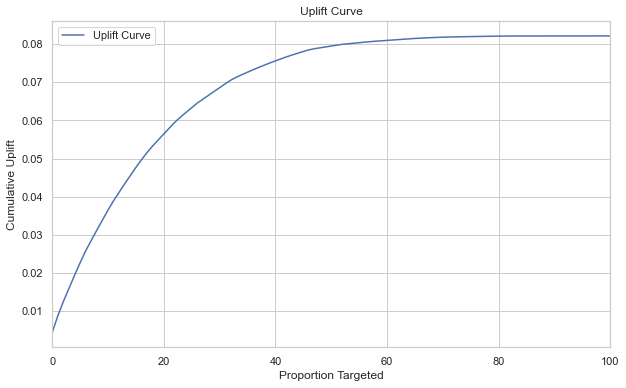

In [48]:
# Split into features and target
X = df.drop('OutcomeT1', axis=1)
y = df['OutcomeT1']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model on treatment group
model_treatment = LogisticRegression()
model_treatment.fit(X_train[X_train['treatment'] == 1].drop('treatment', axis=1), y_train[X_train['treatment'] == 1])

# Train model on control group
model_control = LogisticRegression()
model_control.fit(X_train[X_train['treatment'] == 0].drop('treatment', axis=1), y_train[X_train['treatment'] == 0])

# Predict probabilities
prob_treatment = model_treatment.predict_proba(X_test.drop('treatment', axis=1))[:, 1]
prob_control = model_control.predict_proba(X_test.drop('treatment', axis=1))[:, 1]

# Calculate uplift
uplift = prob_treatment - prob_control

# Sorting the individuals by predicted uplift
order = np.argsort(uplift)[::-1]
sorted_uplift = uplift[order]

# Calculating cumulative uplift
cumulative_uplift = np.cumsum(sorted_uplift) / len(y_test)

# Plotting
plt.figure(figsize=(10, 6))
plt.xlim(0,100)
plt.plot(cumulative_uplift, label='Uplift Curve')
plt.xlabel('Proportion Targeted')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend()
plt.show()

In [49]:
# apply min-max normalisation
#X = df.drop(columns = ['treatment', 'OutcomeT1']).columns
#df[X] = (df[X] - df[X].min()) / (df[X].max() - df[X].min())

In [50]:
X = df.drop(columns = ['treatment', 'OutcomeT1']).columns

normalizer = Normalizer(norm="l2")
normalizer.fit(df[X])

df[X] = normalizer.fit_transform(df[X])

with open(f'storage/normalizer_{TREATMENT}-{OUTCOME}.pkl', 'wb') as f:
    pickle.dump(normalizer, f)

### 4 a. Perform Undersampling Procedure

In [51]:
if UNDERSAMPLE:
    freq_treated = len(df[df['treatment']==1])
    control = df[df['treatment']==0].sample(freq_treated)
    treated = df[df['treatment']==1]
    df = pd.concat((control, treated))
    
print(f'DF lenght after undersampling: {len(df)}')

DF lenght after undersampling: 290


Because the model is a neural-network based architecture, it is usually helpful to apply min-max normalisation which converts the column values to \[0,1\] ranges.

### 4.b Train-Test Splitting

In the cell below, we perform train-test split. Note that we also split the train and test data into two groups: a control group and a treated group. Even though we do not explicItely use for train, it will be useful for the (sub-)group evaluation later on.

In [52]:
# variable setting for treatment
t = 'treatment'
# select the relevant outcome
y = "OutcomeT1" 
# specify test size
test_size = 0.2

# Split groups into train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = [y]), df[['treatment', y]], test_size=test_size, random_state=42)

### 4.c Propensity Score Computation

In [53]:
# predict the propensity score
if PROPENSITY:
    X_train["OutcomeT1"] = y_train["OutcomeT1"]
    X_test["OutcomeT1"] = y_test["OutcomeT1"]
    X = X_train.drop(columns = ['treatment']).columns
    X = X_test.drop(columns = ['treatment']).columns
    ps_model = LogisticRegression(C=1e2, max_iter=10000).fit(X_train[X], y_train['treatment'])
    X_train['ps'] = ps_model.predict_proba(X_train[X])[:, 1]
    X_test['ps'] = ps_model.predict_proba(X_test[X])[:, 1]
    
    # ensure that treatment is last column
    X_train['treatment_new'] =  X_train['treatment']
    X_train = X_train.drop(columns = ['treatment'])
    X_train = X_train.rename(columns = {'treatment_new': 'treatment'})
    
    X_test['treatment_new'] =  X_test['treatment']
    X_test = X_test.drop(columns = ['treatment'])
    X_test = X_test.rename(columns = {'treatment_new': 'treatment'})
    
    #X_train = X_train.drop(columns = ["OutcomeT1"])
else:
    X_train["OutcomeT1"] = y_train["OutcomeT1"]

In [54]:
X = df.drop(columns = ['OutcomeT1', 'treatment']).columns

#X_train = X_train.drop(columns = ["ps"])

# Estimate the average treatment effect (group level)
tau_est = doubly_robust(X_train, X=X, T='treatment', Y='OutcomeT1')
tau_est = torch.tensor(tau_est, dtype = torch.float32).to(device)
print(tau_est)

# drop columns
X_train = X_train.drop(columns = ["OutcomeT1"])

if PROPENSITY == True:
    X_test = X_test.drop(columns = ["OutcomeT1"])

Estimated outcome under control 4.822978968306843.
Estimated outcome under treatment 4.010639354175367.
tensor(-0.7927)


In [55]:
X_train

,sDRS,ij1,ij12,ij2b,ij2c,ij2d,ik3,id4a,ie3e,ih1,...,sCPS,iA2,sAGE_cat,in2f,in2g,in2h,in2j,OutcomeT0,ps,treatment
225,0.037193,0.000000,0.000000,0.012398,0.000000,0.049591,0.0,0.012398,0.037193,0.049591,...,0.024796,0.012398,0.991820,0.0,0.0,0.0,0.0,0.086784,0.211818,0.0
449,0.000000,0.000000,0.000000,0.049576,0.000000,0.000000,0.0,0.000000,0.000000,0.061970,...,0.000000,0.024788,0.991515,0.0,0.0,0.0,0.0,0.086758,0.555381,1.0
495,0.012397,0.000000,0.000000,0.000000,0.000000,0.049587,0.0,0.000000,0.000000,0.024794,...,0.000000,0.024794,0.991744,0.0,0.0,0.0,0.0,0.111571,0.640998,1.0
696,0.013255,0.026509,0.013255,0.053019,0.000000,0.053019,0.0,0.000000,0.039764,0.000000,...,0.039764,0.013255,0.994097,0.0,0.0,0.0,0.0,0.039764,0.673504,1.0
589,0.086905,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.012415,0.024830,...,0.024830,0.024830,0.993195,0.0,0.0,0.0,0.0,0.000000,0.103634,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,0.078574,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.013096,0.000000,0.052383,...,0.013096,0.026191,0.982177,0.0,0.0,0.0,0.0,0.157148,0.443527,1.0
299,0.022206,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.022206,...,0.000000,0.022206,0.999260,0.0,0.0,0.0,0.0,0.000000,0.296874,0.0
6,0.024955,0.000000,0.000000,0.000000,0.012478,0.012478,0.0,0.012478,0.000000,0.037433,...,0.012478,0.024955,0.998208,0.0,0.0,0.0,0.0,0.012478,0.301988,0.0
766,0.000000,0.000000,0.000000,0.000000,0.000000,0.023469,0.0,0.000000,0.000000,0.000000,...,0.035204,0.023469,0.997449,0.0,0.0,0.0,0.0,0.046939,0.375764,1.0


We also want to make sure that the data stuctures are in the right format. For this, we use ``to_tensor``.

In [56]:
y_t = y_train[y_train['treatment']==1][y]
y_c = y_train[y_train['treatment']==0][y]

y_test_t = y_test[y_test['treatment']==1][y]
y_test_c = y_test[y_test['treatment']==0][y]

In [57]:
# convert output to tensors
x, y, y_t, y_c, x_test = to_tensor(X_train), to_tensor(y_train), to_tensor(y_t), to_tensor(y_c), to_tensor(X_test)

### 4.d Model Training

The next step is to train the actual model. The code below sets some preliminary configurations.

In [58]:
# Configurations
lr = 0.001
epochs = 1000
gamma = 2

model = TARnetICFR(x.shape[1], 0.01, hidden_dim = 32*4).to(device)

# Define the loss functions
head_loss = nn.L1Loss() #nn.MSELoss()#nn.L1Loss() #torch.nn.HuberLoss(reduction = 'mean', delta = 1) #nn.MSELoss() # nn.L1Loss() #nn.MSELoss() 

# initialise optimiser
optimizer = optim.Adam(model.parameters(), lr)

u = len(y_t)  / (len(y_t)  + len(y_c))

The code below is the training loop. On each loop, the model passes the data through the models, examines its performance and adjust the weights. Note that this model has four loss components:

1. Component 1 (``loss1``) is to loss on the treated segment of the data.
2. Component 2 (``loss2``) is to loss on the control segment of the data.
3. Component 2 (``loss_cf_3``) is to loss on the counterfactual control segment of the data.
4. Component 2 (``loss_cf_4``) is to loss on the counterfactual treated segment of the data.

In [59]:
# Define loss lists
loss1_lst, loss2_lst, loss3_lst = [], [], []

for epoch in range(epochs):
    # Forward pass
    output_t, output_c, _ = model(x)
    
    # Compute total loss and update the model's parameters
    loss1, loss2 = head_loss(torch.squeeze(output_t), y_t), head_loss(torch.squeeze(output_c), y_c)
    
    pred_c_cf = model.forward_treated(x[x[:,-1]==0])
    loss_cf_3 = (1 - u) * torch.mean((torch.squeeze(pred_c_cf) - (y_c + tau_est))**2)
                 
    pred_t_cf = model.forward_control(x[x[:,-1]==1])
    loss_cf_4 = u * torch.mean((torch.squeeze(pred_t_cf) - (y_t - tau_est))**2)
    
    # losses added
    loss = loss1 + (loss2) + loss_cf_3 + loss_cf_4 #+ (gamma * loss3)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 10000 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}')
        
        # print intermediate results on test
        x_test_t = x_test[x_test[:,-1]==1] 
        x_test_c = x_test[x_test[:,-1]==0] 

        # # examine intermediate factual test performance
        y_t_pred = model.forward_treated(x_test_t).cpu().detach().numpy().reshape(len(x_test_t),)
        y_c_pred = model.forward_control(x_test_c).cpu().detach().numpy().reshape(len(x_test_c),)

        print(f"RMSE for factual treated {mean_squared_error(y_t_pred, y_test_t)}") 
        print(f"MAE for factual treated {mean_absolute_error(y_t_pred, y_test_t)}") 
        print(f"RMSE for factual control {mean_squared_error(y_c_pred, y_test_c)}") 
        print(f"MAE for factual treated {mean_absolute_error(y_c_pred, y_test_c)}") 

Epoch 100/1000 | Loss: 7.6035
RMSE for factual treated 3.6622507937494566
MAE for factual treated 1.4433468808730443
RMSE for factual control 2.618967956832983
MAE for factual treated 1.0302040662084306
Epoch 200/1000 | Loss: 3.3936
RMSE for factual treated 4.593211327631538
MAE for factual treated 1.5461192965507506
RMSE for factual control 0.7942318730304673
MAE for factual treated 0.6934438826782363
Epoch 300/1000 | Loss: 2.4609
RMSE for factual treated 1.3757325286172606
MAE for factual treated 0.7955595528086027
RMSE for factual control 0.37887217890625635
MAE for factual treated 0.5161019920903657
Epoch 400/1000 | Loss: 2.1866
RMSE for factual treated 1.715357846266696
MAE for factual treated 0.7275033287703991
RMSE for factual control 0.39231996446688855
MAE for factual treated 0.44939757803721087
Epoch 500/1000 | Loss: 2.0477
RMSE for factual treated 1.9863420280906487
MAE for factual treated 0.980856116116047
RMSE for factual control 0.5537127392489894
MAE for factual treated 

### 4.e Model Evaluation
Having trained the model, we can no examine the performance on the test set. We first get the predictions for the treated and control groups. Then we visualise the predicted predicted vs. true values. 

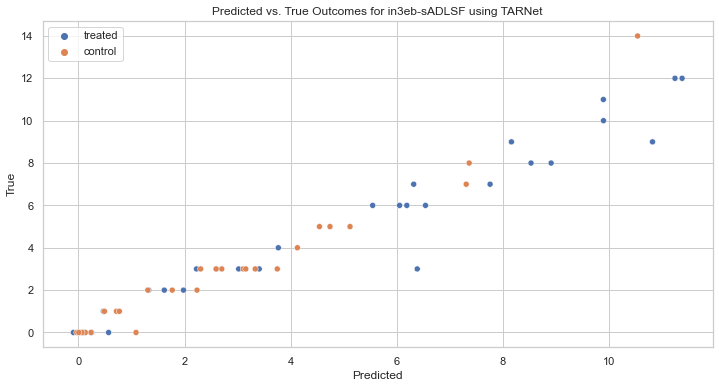

In [60]:
y_t_pred = model.forward_treated(x_test[x_test[:,-1]==1] ).cpu().detach().numpy()
y_c_pred = model.forward_control(x_test[x_test[:,-1]==0] ).cpu().detach().numpy()

machine = "TARNet"
visualise(np.squeeze(y_t_pred), np.squeeze(y_c_pred), y_test_t, y_test_c, machine=machine, target=OUTCOME, intervention=TREATMENT)

Next, we want to estimate the model's predictions of the individual treatment effect. We plot this in an ordered fashion (from most beneficial to least beneficial). The blue dots depict patients. On the y-axis, we find the effect size as predicted by the model. 

ATE_est = 3.5112688541412354 - 4.203131198883057 = -0.6918620467185974.
ATE -0.6918620467185974


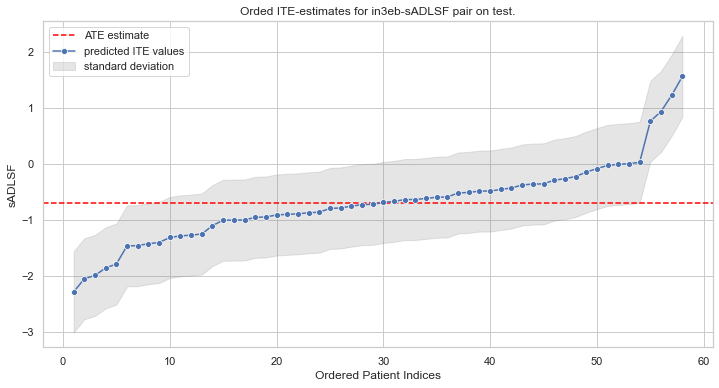

In [61]:
# isolate and disconnect predicted values
y_c_predt1 = model.forward_treated(x_test_c).cpu().detach().numpy()
y_t_predt1 = model.forward_treated(x_test_t).cpu().detach().numpy()
y_t_pred = np.concatenate((y_c_predt1, y_t_predt1))

# isolate and disconnect predicted values
y_c_predt0 = model.forward_control(x_test_c).cpu().detach().numpy() #np.array(y_test_c).reshape(-1,1) #model.forward_control(x_test_c).cpu().detach().numpy()
y_t_predt0 = model.forward_control(x_test_t).cpu().detach().numpy()

y_c_pred = np.concatenate((y_c_predt0, y_t_predt0))

# compute the ites and sort
ites = y_t_pred - y_c_pred
ites = [i[0] for i in ites]
ites = sorted(list(ites))

ate_model_est = np.mean(y_t_pred - y_c_pred)

print(f"ATE_est = {np.mean(y_t_pred)} - {np.mean(y_c_pred)} = {ate_model_est}.")

visualise_ites(np.array(ites), machine = machine, intervention = TREATMENT, target = OUTCOME)

ATE_est = 2.042409658432007 - 2.715006113052368 = -0.67259681224823.
ATE -0.67259681224823


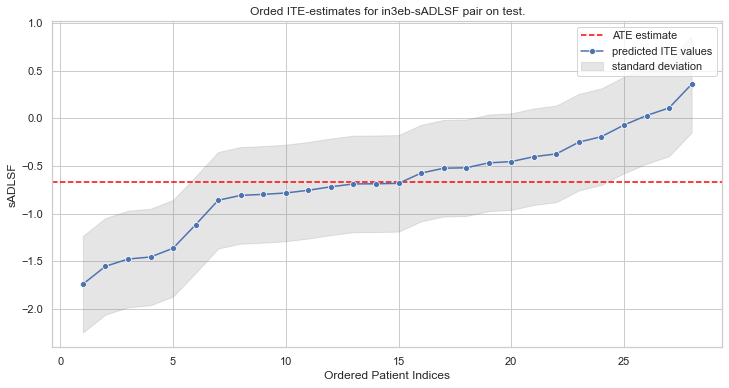

In [62]:
# isolate and disconnect predicted values
y_c_predt1 = model.forward_treated(x_test_c).cpu().detach().numpy()

# isolate and disconnect predicted values
y_c_predt0 = model.forward_control(x_test_c).cpu().detach().numpy() 

# compute the ites and sort
ites = y_c_predt1 - y_c_predt0
ites = [i[0] for i in ites]
ites = sorted(list(ites))

ate_model_est = np.mean(y_c_predt1 - y_c_predt0)

print(f"ATE_est = {np.mean(y_c_predt1)} - {np.mean(y_c_predt0)} = {ate_model_est}.")

visualise_ites(np.array(ites), machine = machine, intervention = TREATMENT, target = OUTCOME)

### 4.e Variable Importances

In [63]:
np.random.seed(42)

# Calculate the baseline performance
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Ensure no gradients are computed
    output_t, output_c, _ = model(x)
baseline_performance = mean_squared_error(output_t, y_t)
print(baseline_performance)

# Initialize a list to hold the feature importances
feature_importances = []
icodes = []
meanings = []
rank = []

collist = X_train.columns

# Calculate the importance for each feature
for i in range(x.shape[1]):  # Iterate over each feature
    # Save the original feature
    original_feature = x[:, i].clone()
    # Permute the feature
    permuted_feature = original_feature[torch.randperm(original_feature.size(0))]
    x[:, i] = permuted_feature
    
    # Calculate performance with the permuted data
    with torch.no_grad():
        output_t, output_c, _ = model(x)
        
    permuted_performance_t = mean_squared_error(output_t, y_t)
    permuted_performance_c = mean_squared_error(output_c, y_c)
    
    permuted_performance = permuted_performance_t + permuted_performance_t
    
    # Calculate the importance as the change in performance
    importance = baseline_performance - permuted_performance
    feature_importances.append(importance)
    
    # Restore the original feature
    x[:, i] = original_feature
    
# Rank the features by their importance
sorted_features = np.argsort(feature_importances)[::-1]  # Indices of features, sorted by importance

# Print the feature importances
print("Feature importances:")
for i, feature_index in enumerate(sorted_features):
    #print(f"Feature {feature_index}: Importance {feature_importances[feature_index]}")
    icode = collist[feature_index]
    icodes.append(icode.lower())
    
    try:
        item = encoding[icode.lower()]
        #print(item)
        meanings.append(item)
    except KeyError:
        #print(f'{icode} not found')
        meanings.append(f'{icode} not found')
    #print("==================================================")
    
rankings = pd.DataFrame(icodes, columns = ['icodes'])
rankings['meanings'] = meanings
rankings['importance_values'] = feature_importances

rankings = rankings.sort_values(by = 'importance_values')
rankings = rankings.reset_index().drop(columns = 'index')
rankings

0.359951
Feature importances:


,icodes,meanings,importance_values
0,treatment,treatment not found,-110.447388
1,ps,ps not found,-93.761566
2,outcomet0,OutcomeT0 not found,-71.574272
3,ij6a,"Conditions diseases make cognitive, ADL, mood,...",-34.736660
4,in2j,Past 3 days: Ventilator,-9.303861
5,in2h,Past 3 days: Tracheostomy care,-6.365430
6,il7,"Foot problems, eg bunions, hammertoes, overlap...",-2.409201
7,in2f,Past 3 days: Radiation,-2.303874
8,ij2c,Dizziness,-1.673303
9,sage_cat,sAGE_cat not found,-1.512249


## Save Model

In [64]:
model

TARnetICFR(
  (phi): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): ELU(alpha=1.0)
  )
  (y0_hidden): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
  (y1_hidden): Sequential(
    (0): Linear(in_features=128,

In [65]:
model = model
location = 'storage'

In [66]:
# save model
with open(f'storage/model_{TREATMENT}-{OUTCOME}.pkl', 'wb') as f:
    pickle.dump(model, f)

In [67]:
# load model
with open(f'storage/model_{TREATMENT}-{OUTCOME}.pkl', 'rb') as b:
    loaded_model = pickle.load(b)

In [68]:
loaded_model

TARnetICFR(
  (phi): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): ELU(alpha=1.0)
  )
  (y0_hidden): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
  (y1_hidden): Sequential(
    (0): Linear(in_features=128,